In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
path = "sensorlog.txt.bck"
with open(path) as f:
    file_content = f.readlines()

In [3]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

generator = chunks(file_content, 105)

In [4]:
time_steps = list(generator)

In [5]:
df = pd.DataFrame([x.split('|')[0:2] for l in time_steps for x in l ])

In [2]:
def process_timestep(data):
    sensor_readings = {}
    for raw_reading in data:
        name, value = [x.strip() for x in raw_reading.split("|")][0:2]
        if "." in value:
            value = float(value)
        elif "0x" in value:
            value = int(value,16)
        sensor_readings[name] = value
    return sensor_readings

In [7]:
processed_timesteps = [process_timestep(x) for x in time_steps]

df = pd.DataFrame(processed_timesteps)

In [8]:
psus = [f"PSU{x} Input" for x in range(1,5)]
psus

['PSU1 Input', 'PSU2 Input', 'PSU3 Input', 'PSU4 Input']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5bff5b390>,
      dtype=object)

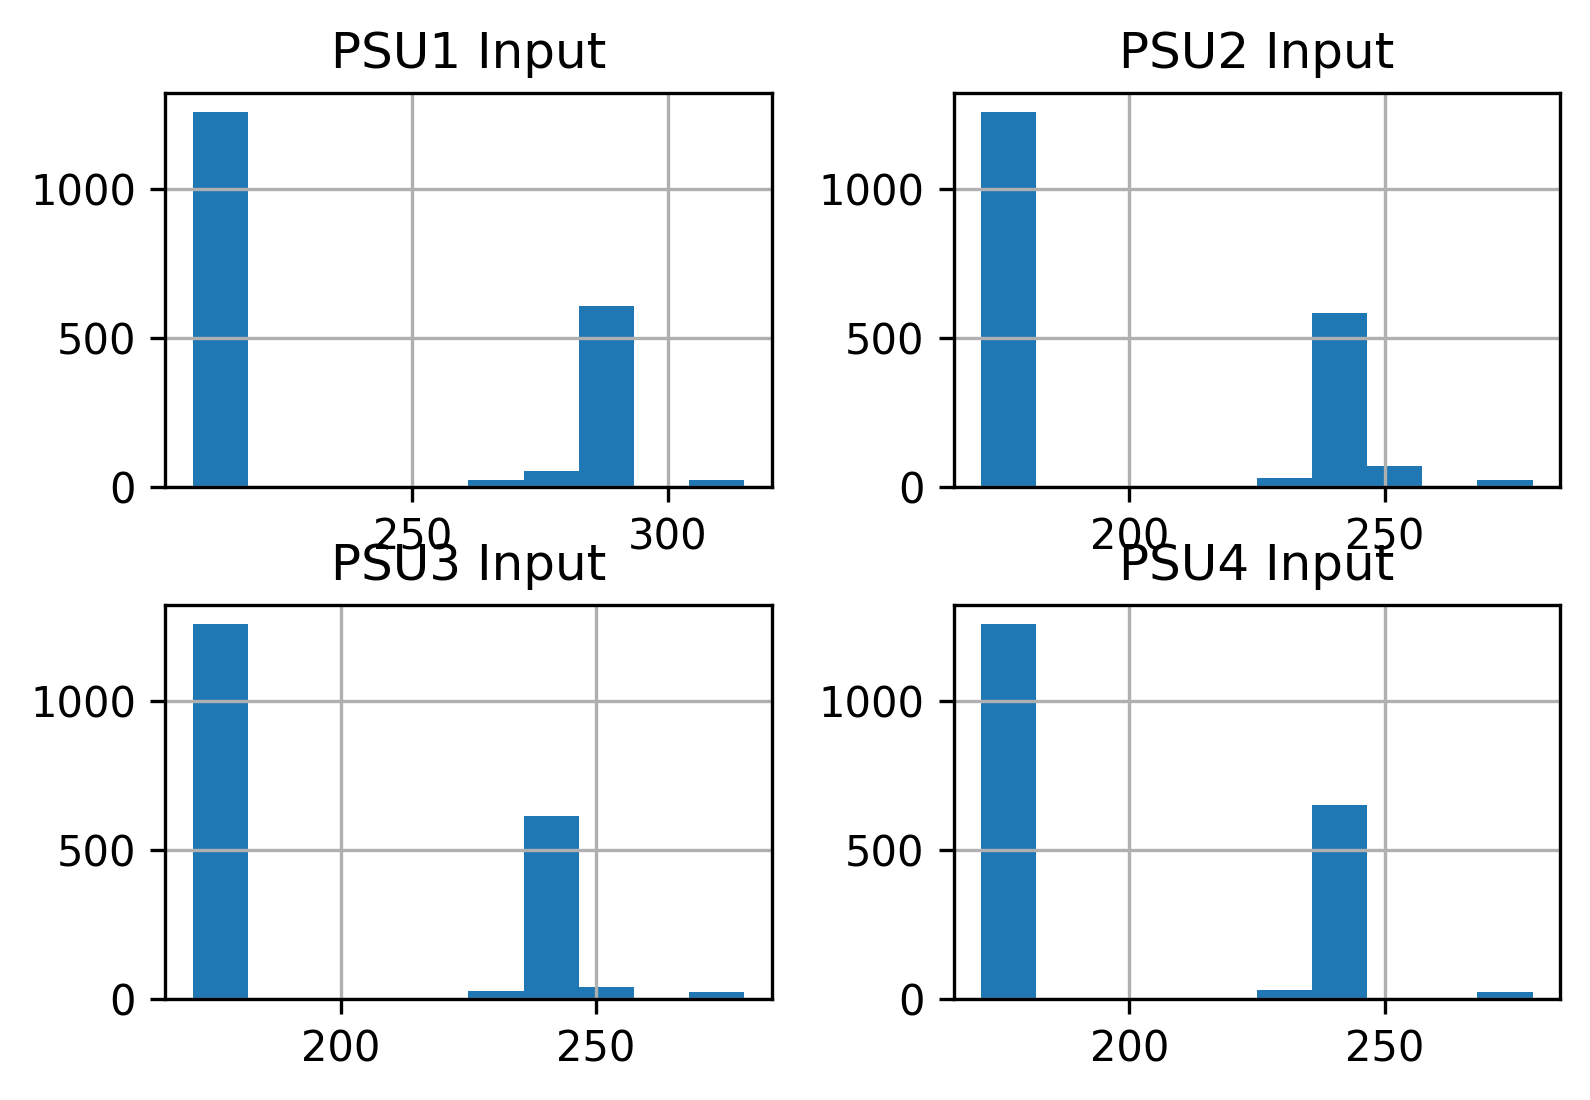

In [11]:
df[psus].hist()

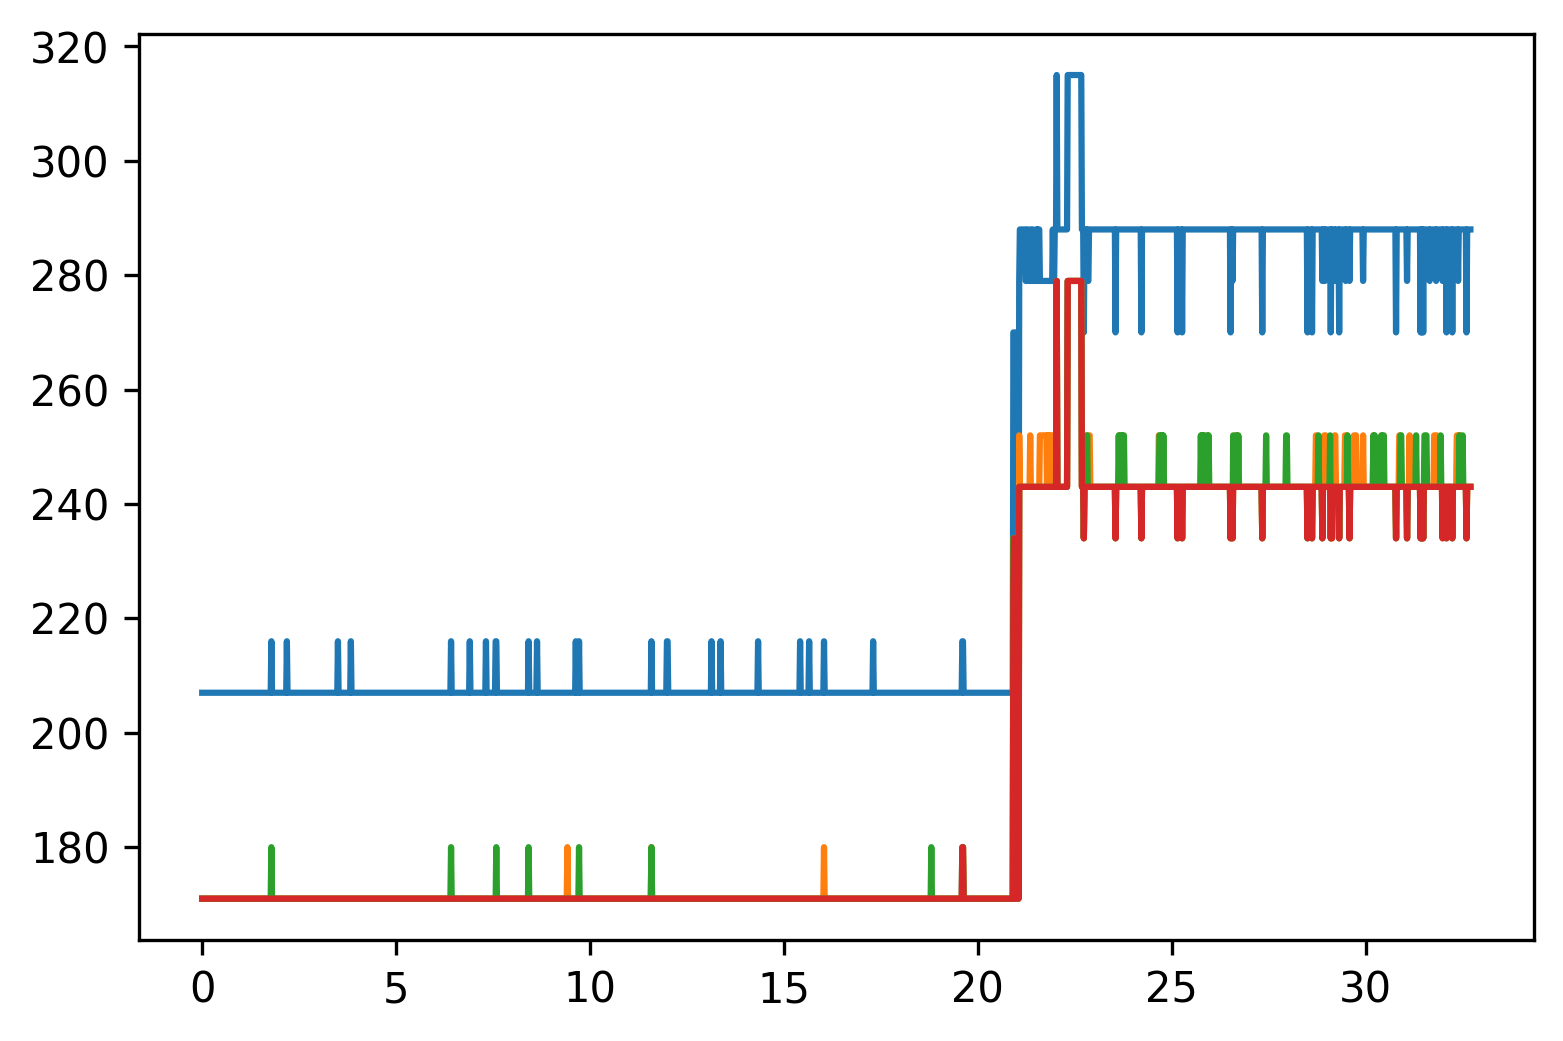

In [13]:
plt.plot(np.arange(len(df[psus]))/60,df[psus])

In [51]:
df[psus].describe()

,PSU1 Input,PSU2 Input,PSU3 Input,PSU4 Input
count,732.000000,732.000000,732.00000,732.0
mean,207.196721,171.024590,171.07377,171.0
std,1.316876,0.470116,0.81203,0.0
min,207.000000,171.000000,171.00000,171.0
25%,207.000000,171.000000,171.00000,171.0
50%,207.000000,171.000000,171.00000,171.0
75%,207.000000,171.000000,171.00000,171.0
max,216.000000,180.000000,180.00000,171.0


In [55]:
all_data = np.array(df[psus])

In [73]:
np.sum(all_data)/60/12*24/1000*365

6414.948000000001

In [72]:
207.196721 +171.024590 +171.07377+171.0

720.295081

In [3]:
!sudo pip3 install nvidia-ml-py3

  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-cp36-none-any.whl size=19192 sha256=18278db14c0e6b03ca8d3a85d3dd4fbd039f8ce64c4325ced947397eb426e7ca
  Stored in directory: /home/felix/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
Successfully built nvidia-ml-py3


In [79]:
import nvidia_smi as smi
import subprocess
import time
from datetime import datetime
smi.nvmlInit()
#smi.nvmlShutdown()

In [80]:
handles = []
num_devices = smi.nvmlDeviceGetCount()
for id in range(num_devices):
    handles.append(smi.nvmlDeviceGetHandleByIndex(id))
print(f"found {num_devices} GPUs")

found 8 GPUs


In [81]:
def read_data():
    tmp = {
        "timestamp":str(datetime.now())
    }
    for id,handle in enumerate(handles):
        res = smi.nvmlDeviceGetUtilizationRates(handle)
        #print(smi.nvmlDeviceGetClockInfo(handle,smi.NVML_CLOCK_MEM))
        #print(smi.nvmlDeviceGetApplicationsClock(handle,smi.NVML_CLOCK_MEM))
        #print(smi.nvmlDeviceGetPciInfo(handle))
        #print(smi.nvmlDeviceGetPowerState(handle))
        #print(smi.nvmlDeviceGetComputeRunningProcesses(handle))
        #print(smi.nvmlDeviceGetCurrPcieLinkWidth(handle))

        #print(smi.nvmlDeviceGetPowerUsage(handle))
        #print(smi.nvmlDeviceGetTemperature(handle,smi.NVML_TEMPERATURE_GPU))
        #print(smi.nvmlDeviceGetPcieThroughput(handle,smi.NVML_PCIE_UTIL_TX_BYTES))
        #print(smi.nvmlDeviceGetPcieThroughput(handle,smi.NVML_PCIE_UTIL_RX_BYTES))
        tmp[f"gpu{id}-util"] = res.gpu
        tmp[f"gpu{id}-mem"] = res.memory

        tmp[f"gpu{id}-power"] = smi.nvmlDeviceGetPowerUsage(handle)
        tmp[f"gpu{id}-tmp"] = smi.nvmlDeviceGetTemperature(handle,smi.NVML_TEMPERATURE_GPU)
        tmp[f"gpu{id}-pci-tx"] = smi.nvmlDeviceGetPcieThroughput(handle,smi.NVML_PCIE_UTIL_TX_BYTES)
        tmp[f"gpu{id}-pci-rx"] = smi.nvmlDeviceGetPcieThroughput(handle,smi.NVML_PCIE_UTIL_RX_BYTES)
        #print(tmp)
        #print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')
    return tmp

In [82]:
#%timeit 
data = []    
#data.append(read_data())

In [83]:
def execute_with_output(self, command):
    def sub_routine(cmd):
        popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True)
        for stdout_line in iter(popen.stdout.readline, ""):
            yield stdout_line 
        popen.stdout.close()
        return_code = popen.wait()
        if return_code:
            raise subprocess.CalledProcessError(return_code, cmd)

    #for line in sub_routine(command):
    #    print(line, end="")

In [103]:
for i in range(1*5):
    data.append(read_data())
    time.sleep(0.5-0.0752)
print("warmup-done")
p = subprocess.Popen(["/bin/bash","./train_cinc17.sh"])#, stdout=subprocess.PIPE)
while p.poll() is None:
    #for line in iter(p.stdout.readline, ''):  # replace '' with b'' for Python 3
    #    print(line)
    data.append(read_data())
    time.sleep(0.5-0.0752)
import pickle
from datetime import datetime
with open(f"data_1_{str(datetime.now())}.pkl","wb") as f:
    pickle.dump(data,f)

warmup-done


In [123]:
df = pd.DataFrame(data)

In [131]:
df

,timestamp,gpu0-util,gpu0-mem,gpu0-power,gpu0-tmp,gpu0-pci-tx,gpu0-pci-rx,gpu1-util,gpu1-mem,gpu1-power,...,gpu6-power,gpu6-tmp,gpu6-pci-tx,gpu6-pci-rx,gpu7-util,gpu7-mem,gpu7-power,gpu7-tmp,gpu7-pci-tx,gpu7-pci-rx
0,2020-01-07 17:59:00.012995,0,0,43040,35,0,0,0,0,45933,...,44034,36,0,0,0,0,43551,33,0,0
1,2020-01-07 17:59:01.065664,0,0,43040,35,0,0,0,0,45933,...,44034,36,0,0,0,0,43551,33,0,0
2,2020-01-07 17:59:02.034830,0,0,43011,35,0,0,0,0,45933,...,44034,36,0,0,0,0,43522,33,0,0
3,2020-01-07 17:59:02.881079,0,0,43011,35,0,0,0,0,45933,...,43551,36,0,0,0,0,43551,33,0,0
4,2020-01-07 17:59:03.789307,0,0,43040,35,0,0,0,0,45933,...,44034,36,0,0,0,0,43551,33,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,2020-01-07 19:25:21.039921,73,37,200225,49,479000,4172000,0,0,60200,...,58394,36,0,0,0,0,57431,32,0,0
2130,2020-01-07 19:25:21.863669,77,47,210756,49,510000,2010000,0,0,60200,...,58394,36,0,0,0,0,57431,32,0,0
2131,2020-01-07 19:25:22.708549,2,0,72745,47,0,0,0,0,60280,...,58433,36,0,0,0,0,57431,32,0,0
2132,2020-01-07 19:25:23.635029,0,0,72312,45,0,0,0,0,60280,...,58433,36,0,0,0,0,57431,32,0,0


In [92]:
import os
os.getcwd()

'/workspace/telemed5000/ecg'

In [106]:
timestamps = pd.read_csv("timestamp_log2020-01-07 19:14:04.076241.csv")

In [156]:
epoch_begin = timestamps[timestamps.event=="epoch_begin"]
epoch_end = timestamps[timestamps.event=="epoch_end"]
batch_begin = timestamps[timestamps.event=="batch_begin"]

In [117]:
timestamps['timestamp']= pd.to_datetime(timestamps['timestamp']) 

In [126]:
df['timestamp']= pd.to_datetime(df['timestamp']) 
df.dtypes

timestamp      datetime64[ns]
gpu0-util               int64
gpu0-mem                int64
gpu0-power              int64
gpu0-tmp                int64
gpu0-pci-tx             int64
gpu0-pci-rx             int64
gpu1-util               int64
gpu1-mem                int64
gpu1-power              int64
gpu1-tmp                int64
gpu1-pci-tx             int64
gpu1-pci-rx             int64
gpu2-util               int64
gpu2-mem                int64
gpu2-power              int64
gpu2-tmp                int64
gpu2-pci-tx             int64
gpu2-pci-rx             int64
gpu3-util               int64
gpu3-mem                int64
gpu3-power              int64
gpu3-tmp                int64
gpu3-pci-tx             int64
gpu3-pci-rx             int64
gpu4-util               int64
gpu4-mem                int64
gpu4-power              int64
gpu4-tmp                int64
gpu4-pci-tx             int64
gpu4-pci-rx             int64
gpu5-util               int64
gpu5-mem                int64
gpu5-power

In [136]:
lastxp = df[df.timestamp > pd.to_datetime("2020-01-07 19:00:00") ]

In [280]:
lastxp.to_csv("data_1_2020-01-07 19:25:25.639810.csv")

In [151]:
gpu_mem = np.array(lastxp["gpu0-util"])

In [181]:
np.corrcoef([lastxp["gpu0-power"],lastxp["gpu0-util"]],rowvar=True )

array([[1.        , 0.68700664],
       [0.68700664, 1.        ]])

In [200]:
np.array(lastxp[["gpu0-util","gpu0-mem"]])

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [2, 0],
       [0, 0],
       [0, 0]])

In [219]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.array(lastxp[["gpu0-util","gpu0-mem"]]), lastxp["gpu0-power"])

In [220]:
reg.score(np.array(lastxp[["gpu0-util","gpu0-mem"]]), lastxp["gpu0-power"])

0.4726841114795101

In [221]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.array(lastxp["gpu0-power"]),reg.predict(np.array(lastxp[["gpu0-util","gpu0-mem"]])))

1256590220.9146333

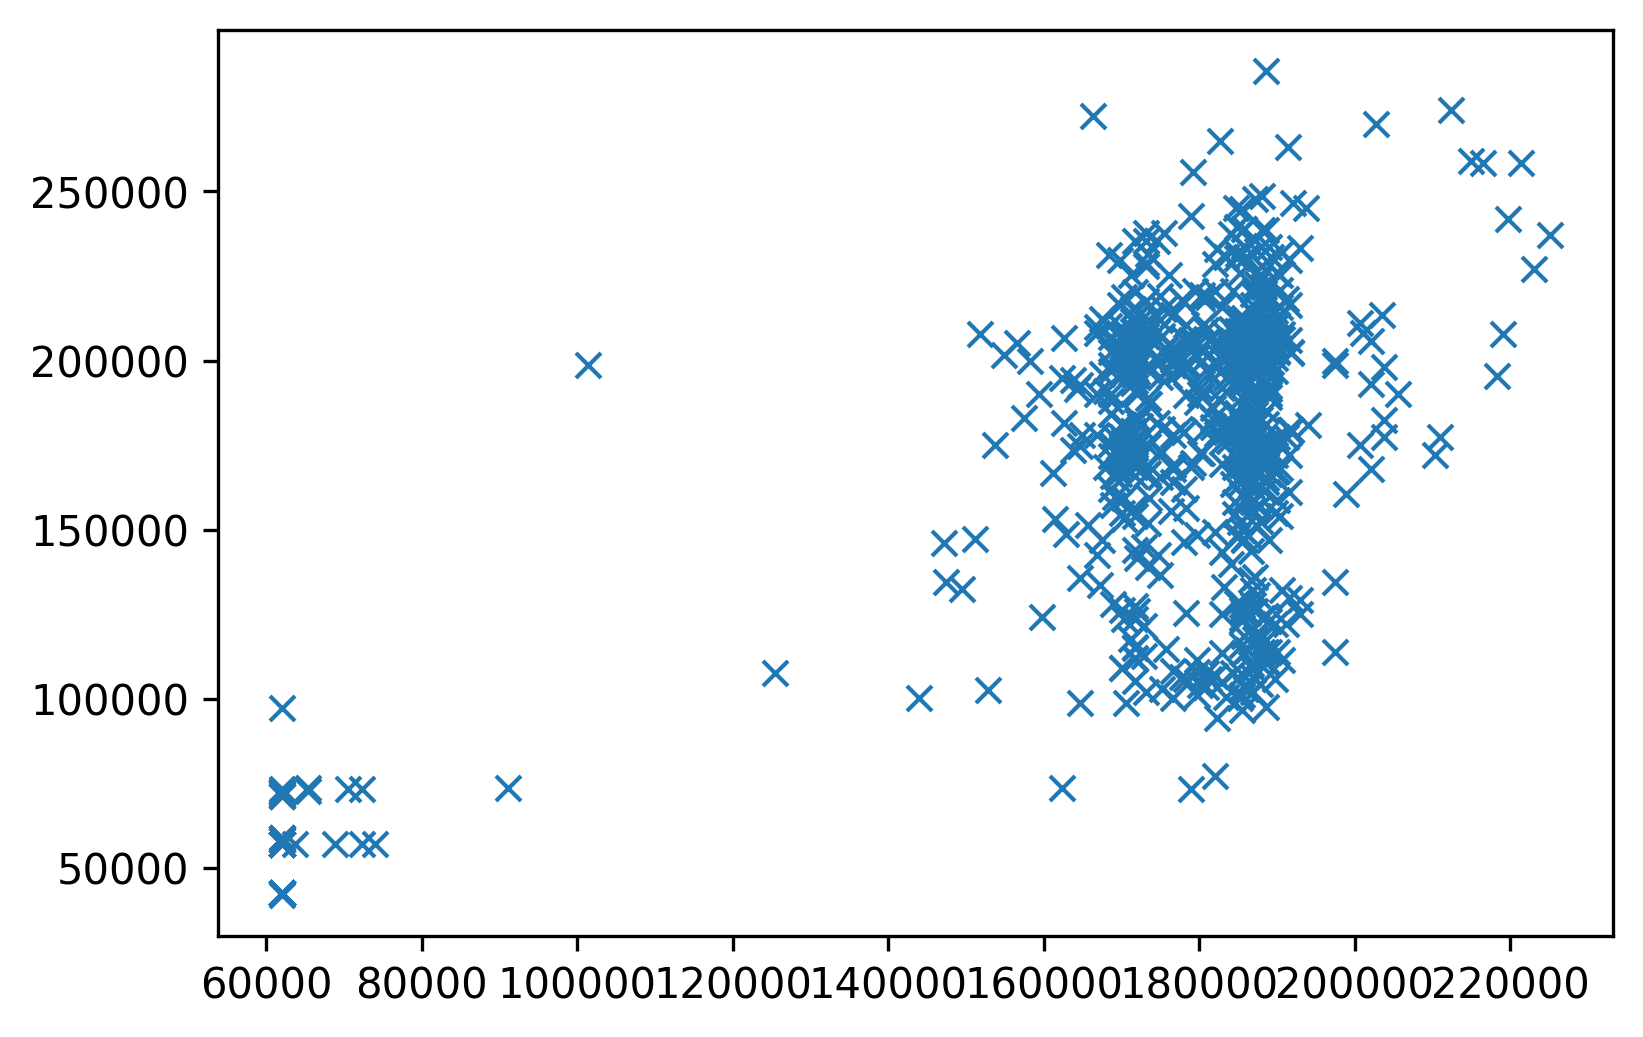

In [222]:
plt.plot(reg.predict(np.array(lastxp[["gpu0-util","gpu0-mem"]])), lastxp["gpu0-power"],"x")

In [230]:
?sig.butter

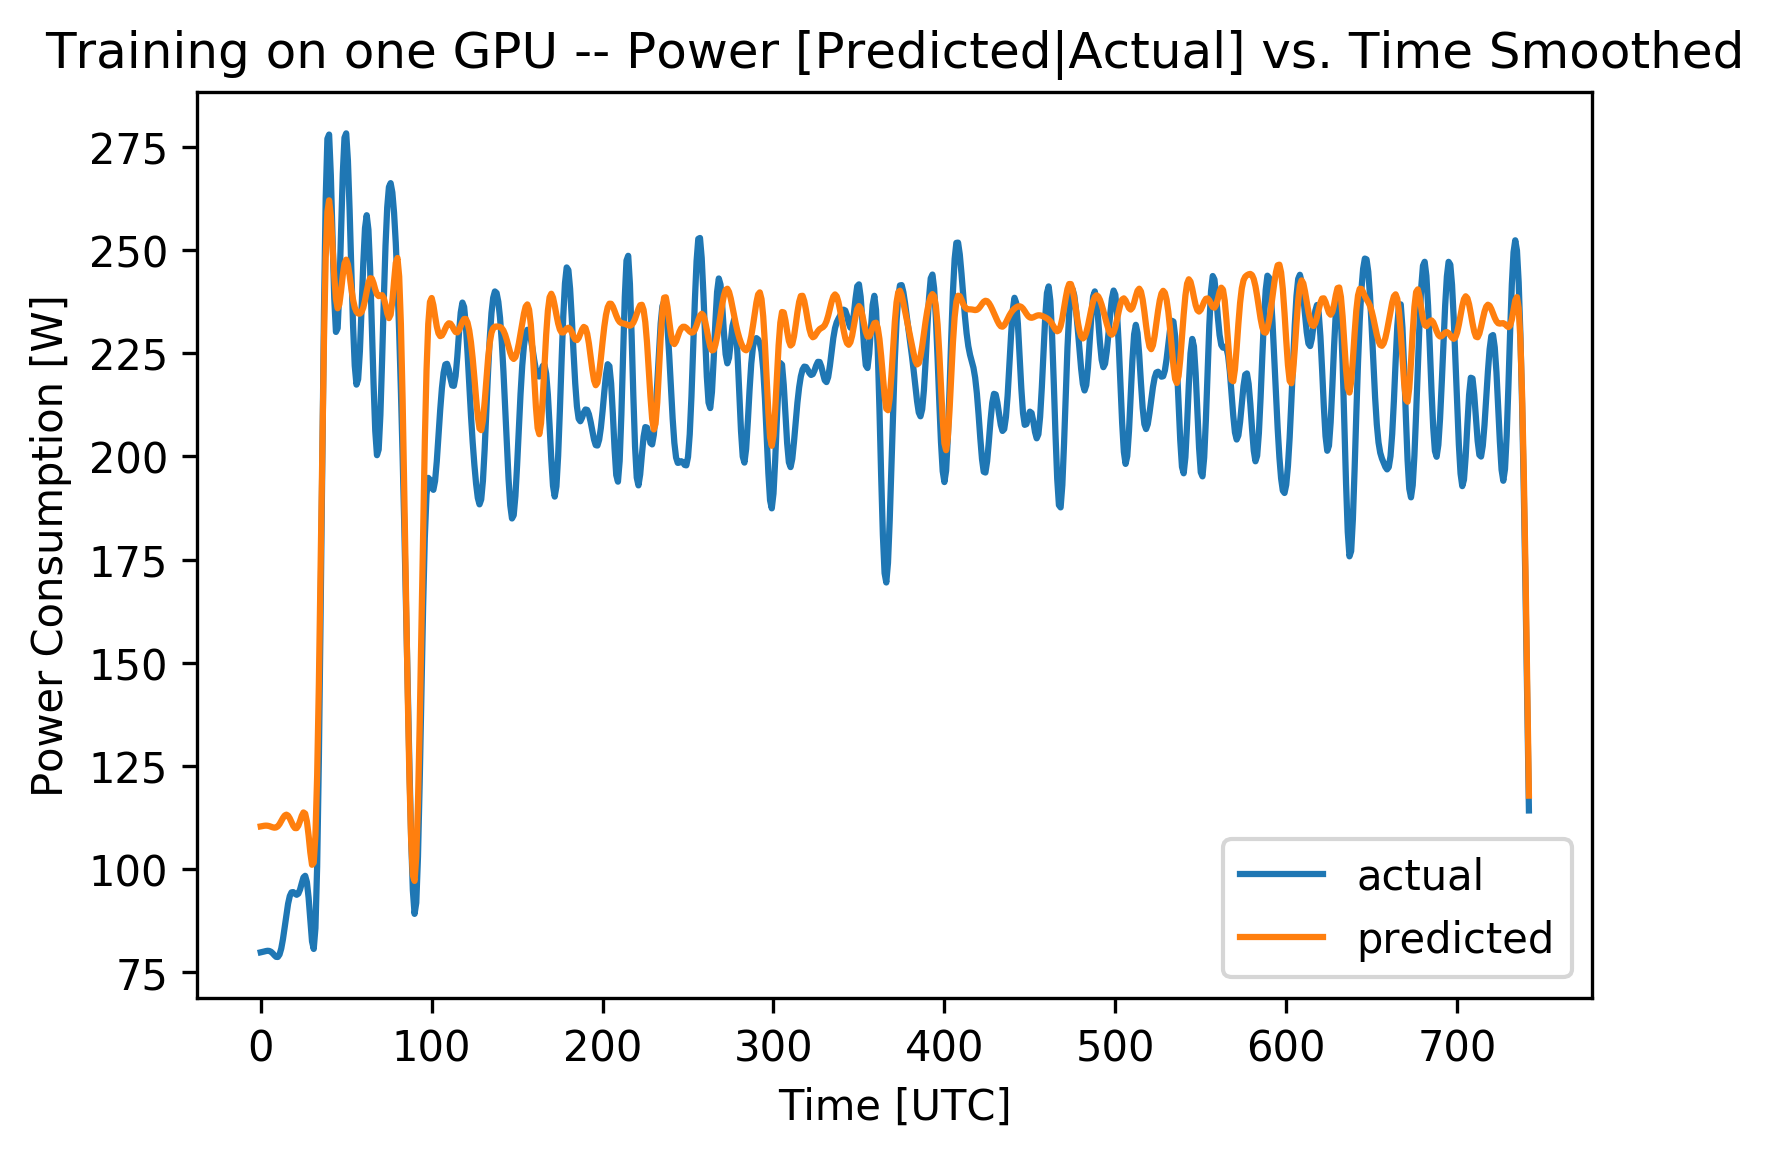

In [265]:
import scipy.signal as sig
coefs = sig.butter(4,[0.00001,0.2],"bandpass")

plt.plot(sig.filtfilt(*coefs,np.array(lastxp["gpu0-power"]))/1000)
plt.plot(sig.filtfilt(*coefs,reg.predict(np.array(lastxp[["gpu0-util","gpu0-mem"]])))/1000)
plt.title("Training on one GPU -- Power [Predicted|Actual] vs. Time Smoothed")
plt.xlabel("Time [UTC]")
plt.ylabel("Power Consumption [W]")
plt.legend(["actual","predicted"])

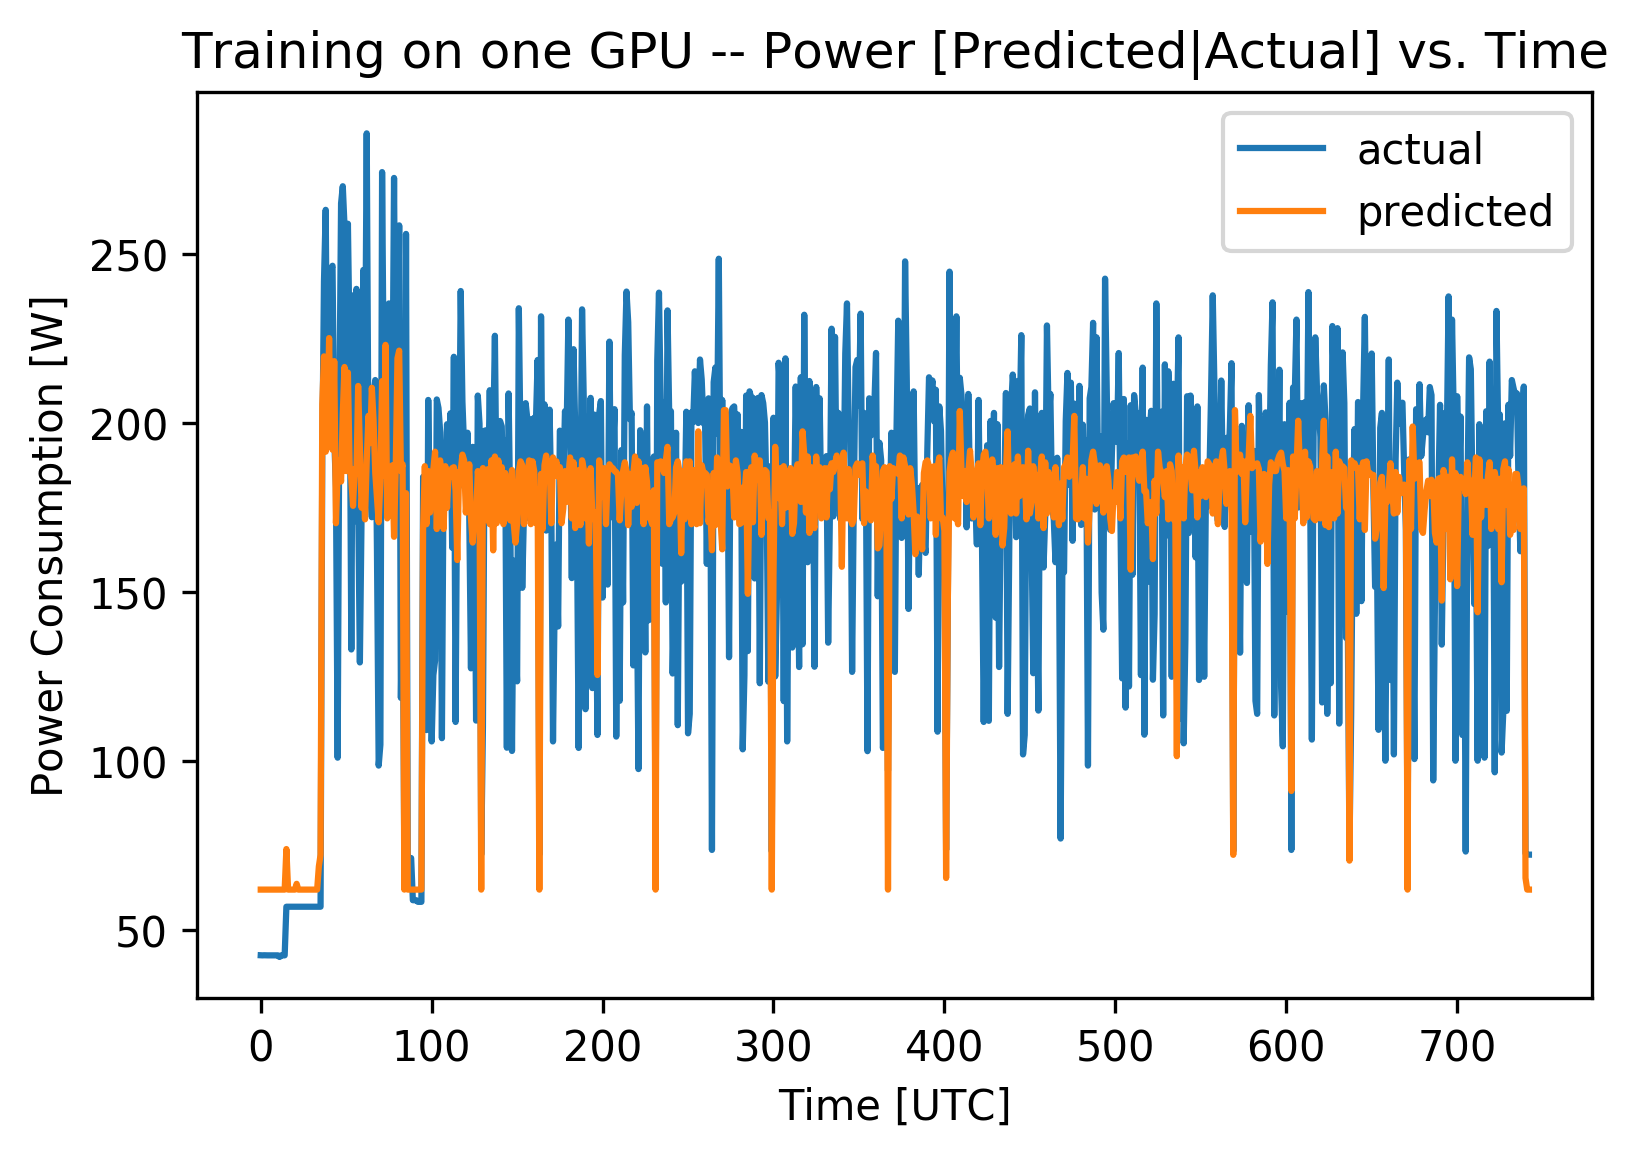

In [261]:
plt.plot(np.array(lastxp["gpu0-power"])/1000)
plt.plot(reg.predict(np.array(lastxp[["gpu0-util","gpu0-mem"]]))/1000)
plt.title("Training on one GPU -- Power [Predicted|Actual] vs. Time")
plt.xlabel("Time [UTC]")
plt.ylabel("Power Consumption [W]")
plt.legend(["actual","predicted"])

In [208]:
reg.predict(np.array(lastxp[["gpu0-util","gpu0-mem"]])[500:502])/1000


array([176.61498212, 185.4647203 ])

In [209]:
np.array(lastxp["gpu0-power"])[500:502]/1000

array([198.788, 194.35 ])

Text(0, 0.5, 'Power Consumption [W]')

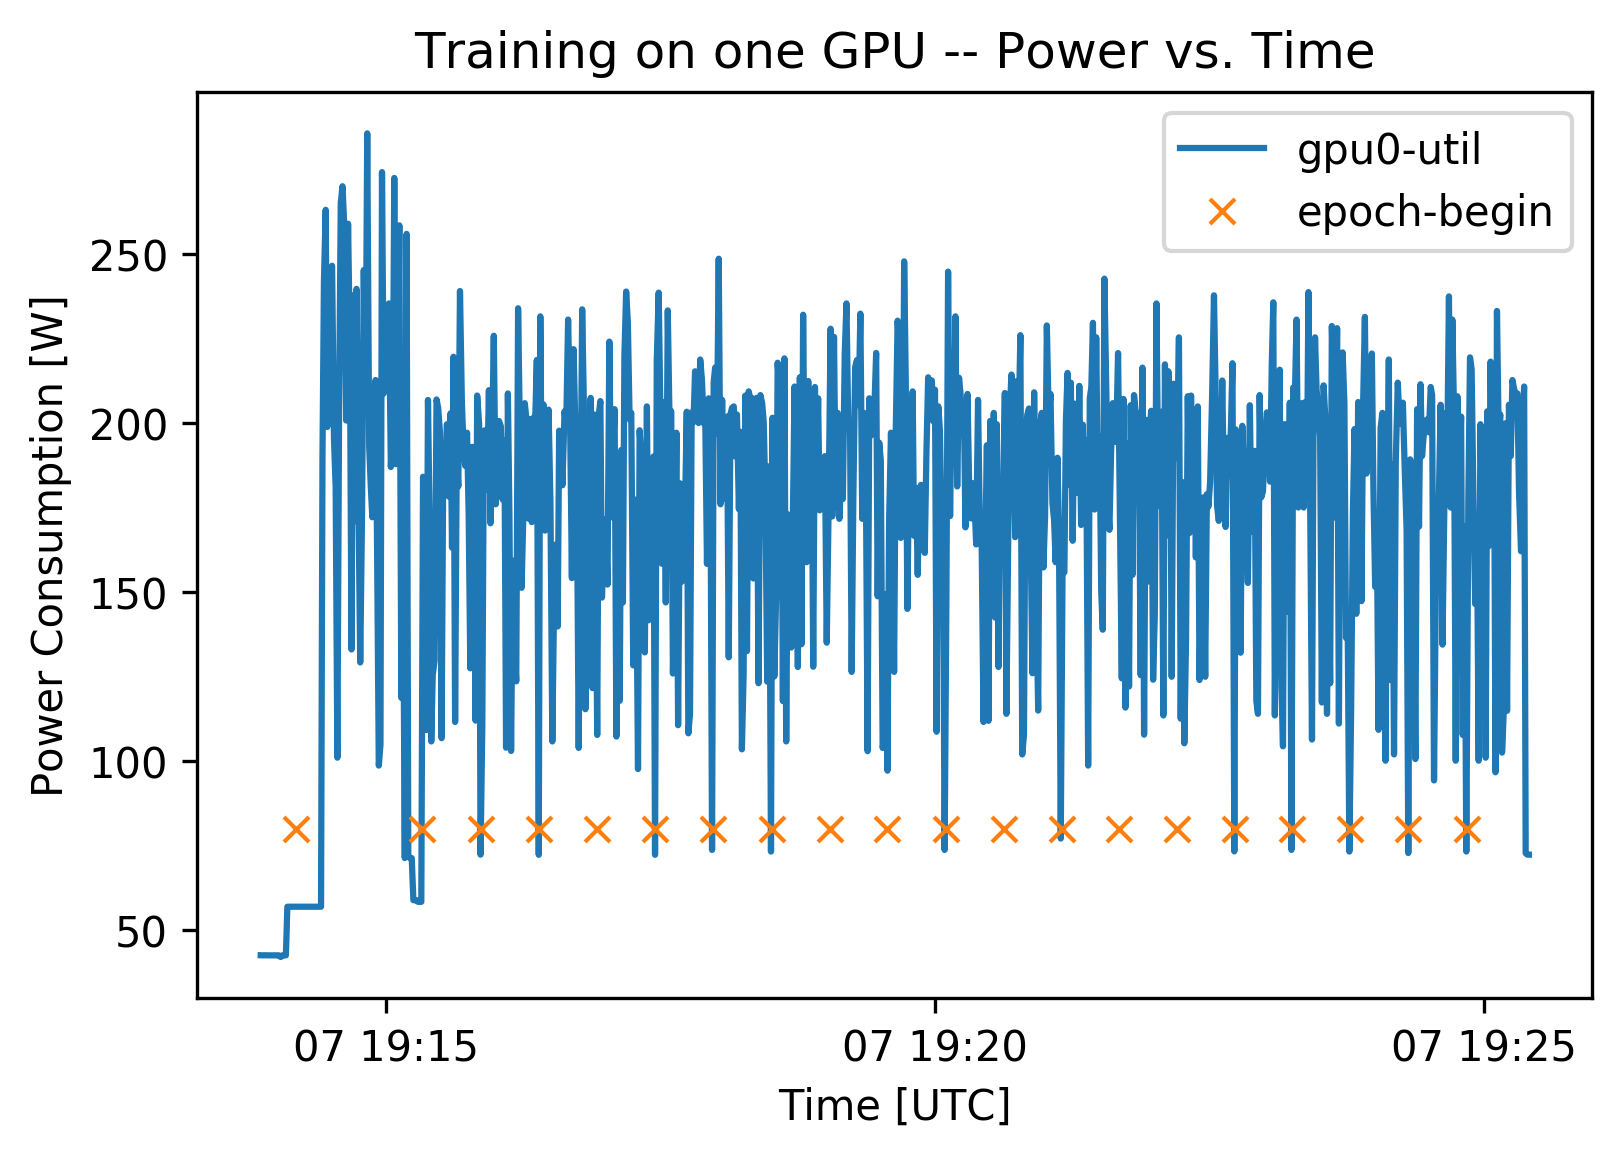

In [258]:
#plt.plot(np.array(lastxp["timestamp"])[:-1], gpu_mem[1:]-gpu_mem[:-1])
#plt.plot(np.array(lastxp["timestamp"]), lastxp["gpu0-util"])
plt.plot(np.array(lastxp["timestamp"]), lastxp["gpu0-power"]/1000)
plt.plot(epoch_begin['timestamp'], np.full(len(epoch_begin),80),"x")
#plt.plot(batch_begin['timestamp'], np.full(len(batch_begin),20),"^")
#plt.plot(df["gpu0-power"][:1000]/3000)
plt.legend(["gpu0-util", "epoch-begin"])
plt.title("Training on one GPU -- Power vs. Time")
plt.xlabel("Time [UTC]")
plt.ylabel("Power Consumption [W]")

Text(0, 0.5, 'GPU Utilization [%]')

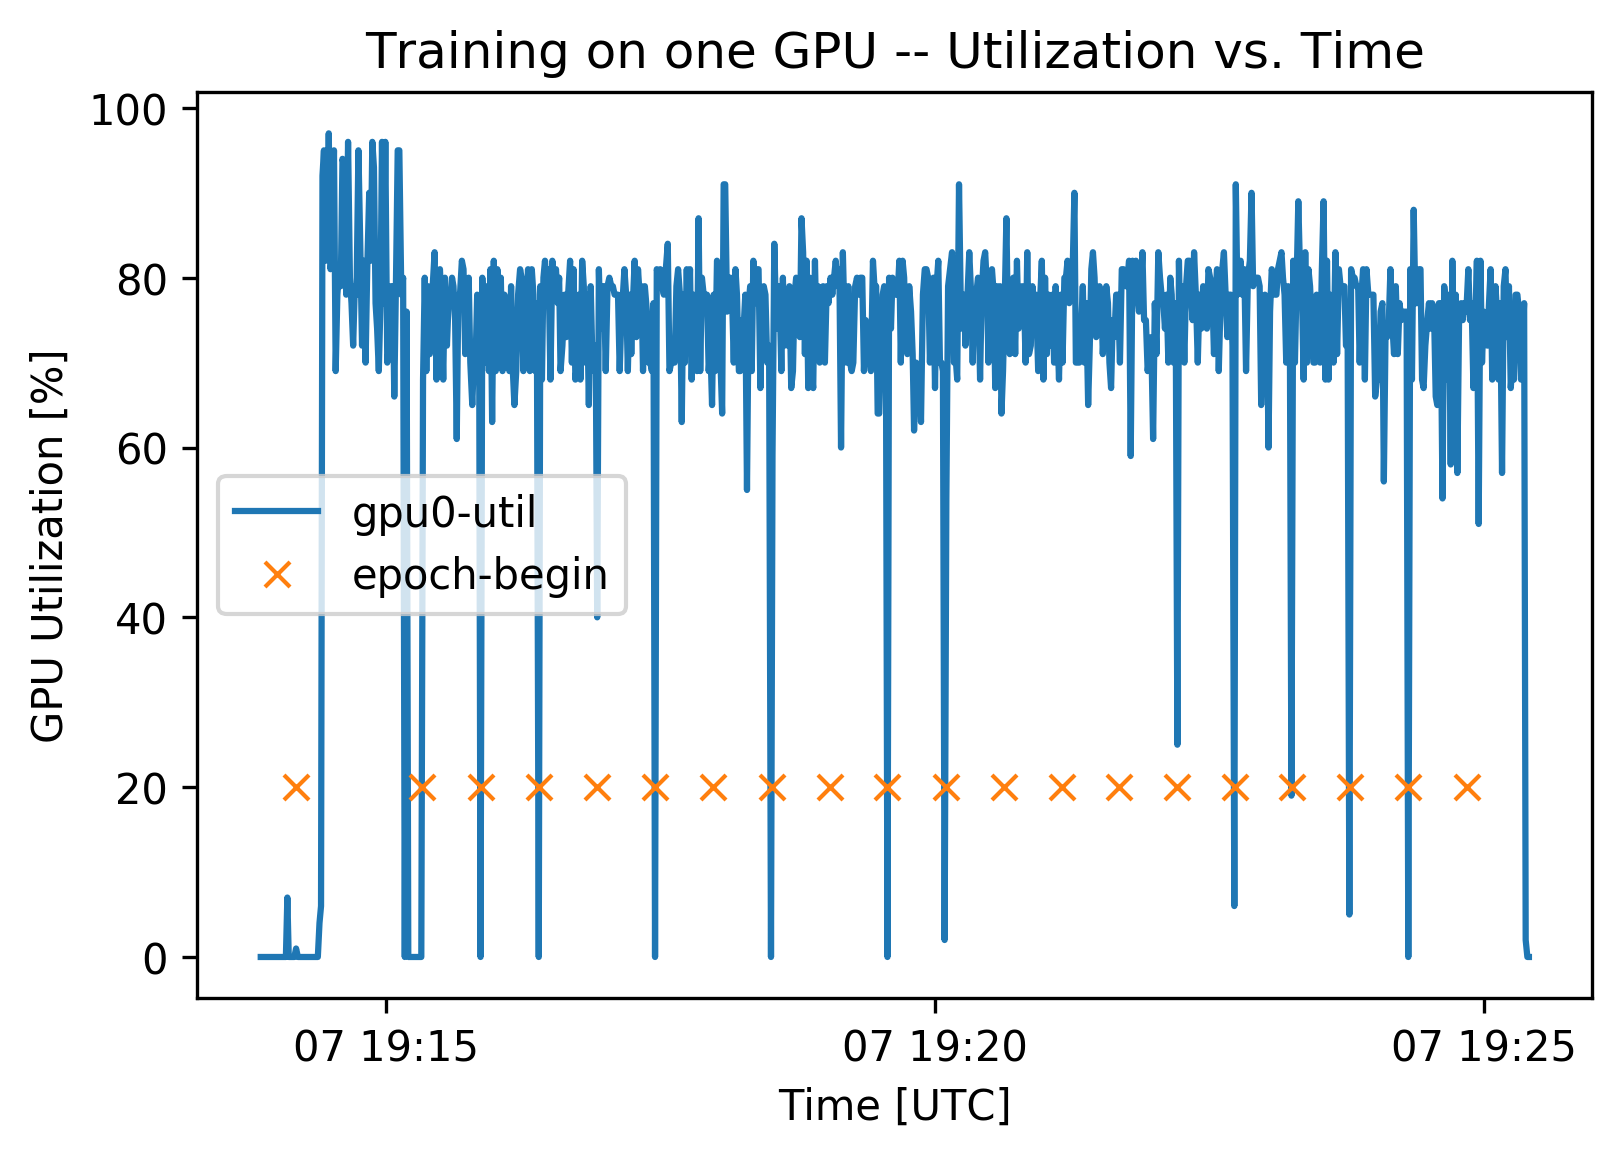

In [176]:
#plt.plot(np.array(lastxp["timestamp"])[:-1], gpu_mem[1:]-gpu_mem[:-1])
plt.plot(np.array(lastxp["timestamp"]), lastxp["gpu0-util"])
#plt.plot(np.array(lastxp["timestamp"]), lastxp["gpu0-power"]/1000)
plt.plot(epoch_begin['timestamp'], np.full(len(epoch_begin),20),"x")
#plt.plot(batch_begin['timestamp'], np.full(len(batch_begin),20),"^")
#plt.plot(df["gpu0-power"][:1000]/3000)
plt.legend(["gpu0-util", "epoch-begin"])
plt.title("Training on one GPU -- Utilization vs. Time")
plt.xlabel("Time [UTC]")
plt.ylabel("GPU Utilization [%]")

In [1]:
epoch_begin['timestamp'][2]

NameError: name 'epoch_begin' is not defined

In [23]:
import pickle
from datetime import datetime
with open(f"data_1_{str(datetime.now())}.pkl","wb") as f:
    pickle.dump(data,f)

In [10]:
import matplotlib.pyplot as plt
import matp()lotlib.animation as animation
from IPython.display import HTML

# Parameters
x_len = 200         # Number of points to display
y_range = [10, 40]  # Range of possible Y values to display
temp_c = 0

# Create figure for plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xs = list(range(0, 200))
ys = [0] * x_len
ax.set_ylim([0,10000000])


# Create a blank line. We will update the line in animate
line, = ax.plot(xs, ys)

# Add labels
plt.title('TMP102 Temperature over Time')
plt.xlabel('Samples')
plt.ylabel('Temperature (deg C)')

def get_data():
    i=15
    while True:
        i+=10
        yield i
        
# This function is called periodically from FuncAnimation
def animate(i, ys):
    #global temp_c
    # Read temperature (Celsius) from TMP102
    temp_c = nvidia_smi.nvmlDeviceGetPowerUsage(handle)/1000

    # Add y to list
    ys.append(temp_c+ys[-1])

    # Limit y list to set number of items
    ys = ys[-x_len:]

    # Update line with new Y values
    line.set_ydata(ys)

    return line,

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig,
    animate, #frames=100,
    fargs=(ys,),
    interval=100,
    blit=True)
plt.show()


SyntaxError: invalid syntax (<ipython-input-10-b70fcaacb099>, line 2)

In [269]:
with open(f"data_1_2020-01-07 19:25:25.639810.pkl","rb") as f:
   unpack_test = pickle.load(f)

In [270]:
unpack_test

[{'timestamp': '2020-01-07 17:59:00.012995',
  'gpu0-util': 0,
  'gpu0-mem': 0,
  'gpu0-power': 43040,
  'gpu0-tmp': 35,
  'gpu0-pci-tx': 0,
  'gpu0-pci-rx': 0,
  'gpu1-util': 0,
  'gpu1-mem': 0,
  'gpu1-power': 45933,
  'gpu1-tmp': 36,
  'gpu1-pci-tx': 0,
  'gpu1-pci-rx': 0,
  'gpu2-util': 0,
  'gpu2-mem': 0,
  'gpu2-power': 43522,
  'gpu2-tmp': 34,
  'gpu2-pci-tx': 0,
  'gpu2-pci-rx': 0,
  'gpu3-util': 0,
  'gpu3-mem': 0,
  'gpu3-power': 43975,
  'gpu3-tmp': 31,
  'gpu3-pci-tx': 0,
  'gpu3-pci-rx': 0,
  'gpu4-util': 0,
  'gpu4-mem': 0,
  'gpu4-power': 43551,
  'gpu4-tmp': 34,
  'gpu4-pci-tx': 0,
  'gpu4-pci-rx': 0,
  'gpu5-util': 0,
  'gpu5-mem': 0,
  'gpu5-power': 43068,
  'gpu5-tmp': 33,
  'gpu5-pci-tx': 0,
  'gpu5-pci-rx': 0,
  'gpu6-util': 0,
  'gpu6-mem': 0,
  'gpu6-power': 44034,
  'gpu6-tmp': 36,
  'gpu6-pci-tx': 0,
  'gpu6-pci-rx': 0,
  'gpu7-util': 0,
  'gpu7-mem': 0,
  'gpu7-power': 43551,
  'gpu7-tmp': 33,
  'gpu7-pci-tx': 0,
  'gpu7-pci-rx': 0},
 {'timestamp': '2020-01-07

In [278]:
?pd.DataFrame.to_csv